# Section 3.1
## Question 3.1.1
Installer les packages


In [1]:
%pip install numpy pandas matplotlib scikit-learn mlxtend prefixspan seaborn umap-learn

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 15.9 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ------ --------------------------------- 6.3/38.1 MB 29.7 MB/s eta 0:00:02
   ----------- ---------------------------- 11.0/38.1 MB 26.5 MB/s eta 0:00:02
   ---------------- ----------------------- 15.7/38.1 MB 24.7 MB/s eta 0:00:01
   --------------------- ------------------ 20.2/38.1 MB 23.6 MB/s eta 0:00:01
   ------------------------- -------------- 23.9/38.1 MB 22.2 MB/s eta 0:00:01
   ---------------------------- ----------- 27.0/38.1 MB 20.9 MB/s eta 0:00:01
   ------------------------------- -------- 30.1/38.1 MB 19.9 MB/s eta 0:00:01
   ---------------------------------- ----- 33.3/38.1 MB 19.2 MB/s eta 0:00:01
   -------------------------------------- 


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importer les librairies et lecture des fichiers .csv et .json

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from recommendation import Recommendation
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from prefixspan import PrefixSpan
from umap import UMAP
import numpy as np

user = pd.read_csv('users_data.csv')
card = pd.read_csv('cards_data.csv')
transaction  = pd.read_csv('transactions_data.csv', dtype={'zip': str, 'mcc': str})

with open('mcc_codes.json', 'r') as f:
        mcc_code = json.load(f)

df_fraudes = pd.read_json("train_fraud_labels.json")
df_fraudes=df_fraudes.reset_index(names='trans_id')
df_fraudes['target'] = df_fraudes['target'].str.lower().map({'no' : False, 'yes' : True})

c:\Users\Christiano\Desktop\IFT599\TP1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Faire des merges pour avoir une seule dataframe

In [3]:
# Fusion des tableaux user et card selon le id user
user_card = pd.merge(user, card, how = 'left', left_on = 'id', right_on='client_id',suffixes=('_user','_card')).drop('client_id',axis = 1)

# Fusion des tableau card et transaction selon le id card
df = pd.merge(user_card, transaction, how = 'left', left_on = 'id_card', right_on='card_id',suffixes=('_user','_transaction')).drop(columns=['card_id','client_id'])
df.rename(columns={'id': 'id_transaction'}, inplace=True)

df=pd.merge(df, df_fraudes, left_on='id_transaction',right_on='trans_id')
df.rename(columns={'target': 'fraude'}, inplace=True)


In [4]:
df.head()

,id_user,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,...,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,trans_id,fraude
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$129.34,Chip Transaction,46284.0,Monterey Park,CA,91754.0,5411,NaN,20624141,False
1,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$8.54,Online Transaction,85247.0,ONLINE,NaN,NaN,5815,NaN,20627900,False
2,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$115.71,Chip Transaction,75781.0,Alhambra,CA,91801.0,5411,NaN,20629016,False
3,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$107.50,Chip Transaction,61195.0,Mira Loma,CA,91752.0,5541,NaN,20652295,False
4,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,$38.75,Chip Transaction,50072.0,La Verne,CA,91750.0,5912,NaN,20662106,False


##  Question 3.1.2

Dans le tableau user, les variables les moins pertinants sont current_age, retirement_age, latitude, longitude. On n'a pas besoin de savoir l'âge du user si on peut le calculer à partir de la date de naissance. La latitude et la longitude ne sont pas nécessaire lorsqu'on possède l'adresse.

In [5]:
drop_col =["current_age","retirement_age","latitude", "longitude"]
df.drop(columns = drop_col,inplace=True)

## Question 3.1.3
les variables les moins pertinants sont current_age, retirement_age, latitude, longitude. On n'a pas besoin de savoir l'âge du user si on peut le calculer à partir de la date de naissance. La latitude et la longitude ne sont pas nécessaire lorsqu'on possède l'adresse
Enlever duplicate

In [6]:
df = df.drop_duplicates(subset=['id_user', 'id_card', 'id_transaction'])

Traitement données manquantes

In [7]:
df.isna().sum()

id_user                        0
birth_year                     0
birth_month                    0
gender                         0
address                        0
per_capita_income              0
yearly_income                  0
total_debt                     0
credit_score                   0
num_credit_cards               0
id_card                        0
card_brand                     0
card_type                      0
card_number                    0
expires                        0
cvv                            0
has_chip                       0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
card_on_dark_web               0
id_transaction                 0
date                           0
amount                         0
use_chip                       0
merchant_id                    0
merchant_city                  0
merchant_state            208407
zip                       221776
mcc       

In [8]:
df.isna().mean()*100

id_user                   0.000000
birth_year                0.000000
birth_month               0.000000
gender                    0.000000
address                   0.000000
per_capita_income         0.000000
yearly_income             0.000000
total_debt                0.000000
credit_score              0.000000
num_credit_cards          0.000000
id_card                   0.000000
card_brand                0.000000
card_type                 0.000000
card_number               0.000000
expires                   0.000000
cvv                       0.000000
has_chip                  0.000000
num_cards_issued          0.000000
credit_limit              0.000000
acct_open_date            0.000000
year_pin_last_changed     0.000000
card_on_dark_web          0.000000
id_transaction            0.000000
date                      0.000000
amount                    0.000000
use_chip                  0.000000
merchant_id               0.000000
merchant_city             0.000000
merchant_state      

Remplace les valeurs dans la colonne errors par no errors afin d'éviter que celle-ci cause problème

In [9]:
df.dropna(subset='id_transaction', inplace=True)
df.fillna({'errors' : 'no error', }, inplace=True)

df.loc[df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'
df.loc[df['merchant_city'] == 'ONLINE', 'zip'] = 'ONLINE'
df.loc[(df['merchant_state'] != "ONLINE") & (df['merchant_state'].str.len() > 2), 'zip'] = "outside US"

In [10]:
df.isna().sum()

id_user                  0
birth_year               0
birth_month              0
gender                   0
address                  0
per_capita_income        0
yearly_income            0
total_debt               0
credit_score             0
num_credit_cards         0
id_card                  0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
id_transaction           0
date                     0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                      0
mcc                      0
errors                   0
trans_id                 0
fraude                   0
dtype: int64

Ajuster type de données

In [11]:

# Ajuster type de données de string à float
for col in ["per_capita_income", "yearly_income", "total_debt", "credit_limit","amount"]:
    df[col] = df[col].replace(r"[\$,]", "", regex=True).astype(float)

# Ajuster type de données de string à datetime
for col,formt in [("acct_open_date",'%m/%Y'),("expires",'%m/%Y'),("date",'%Y-%m-%d %H:%M:%S'),("year_pin_last_changed","%Y")]:
    df[col] = pd.to_datetime(df["acct_open_date"],errors='coerce',format =formt)

# Ajuster type de données de string à bool
for col in ["has_chip","card_on_dark_web"]:
    df[col] = df[col].str.lower().map({"yes": True, "no": False})

## Question 3.1.4
Pour birth_year, birth_month, il  est inutile d'avoir 2 colonnes pour la date de naissance. Dans le tableau transaction les variables merchant_city, merchant_state pourrait juste être une adresse.

## Question 3.1.5
Affichage graphique des données

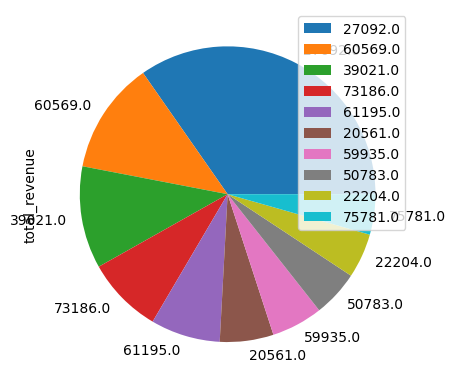

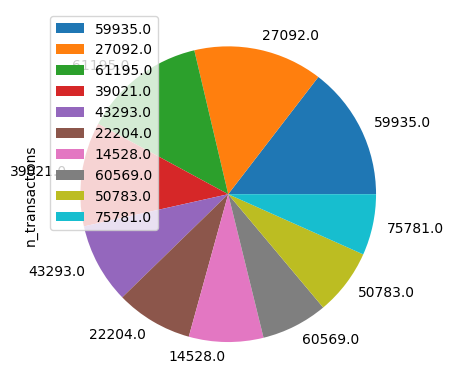

In [12]:
merchant = df.groupby("merchant_id").agg({
    "id_transaction": "count",
    "amount": "sum"
}).rename(columns={
    "id_transaction": "n_transactions",
    "amount": "total_revenue"
})

top_merchant_revenue = merchant.nlargest(10, "total_revenue")
top_merchant_count   = merchant.nlargest(10, "n_transactions")

top_merchant_revenue.plot(kind = 'pie',y = 'total_revenue')
top_merchant_count.plot(kind = 'pie',y = 'n_transactions')
plt.show()



Nous pouvons conclure qu'il existe peut-être une relation entre les marchands qui font le plus de transactions et les marchands qui font le plus de revenu puis qu'il y  a une grande majorité des marchands qui sont dans les deux graphes (59935,27092,61195,39021,22204,60569,50783,75781).

## Question 3.1.6
Nous avons ajouté la colonne mcc_description ainsi que son encodage. L’encodage choisi est le LabelEncoder, appliqué en tenant compte du type de carte utilisé..

In [13]:
df['mcc_description'] = df['mcc'].map(mcc_code).astype(str)


encoder = LabelEncoder()
df['card_type_encode'] = encoder.fit_transform(df["card_type"])

In [14]:
df['mcc_description']

0                Grocery Stores, Supermarkets
1          Digital Goods - Media, Books, Apps
2                Grocery Stores, Supermarkets
3                            Service Stations
4                  Drug Stores and Pharmacies
                          ...                
1711933            Telecommunication Services
1711934          Grocery Stores, Supermarkets
1711935                 Fast Food Restaurants
1711936                      Service Stations
1711937                      Service Stations
Name: mcc_description, Length: 1711938, dtype: object

# Section 3.2

In [15]:
q1 = df['amount'].quantile(0.25)
q2 = df['amount'].quantile(0.50)
q3 = df['amount'].quantile(0.75)

def categorize_amount_quartile ( x ) :
    if x <= q1 :
        return 'amount_low'
    elif x <= q2 :
        return  'amount_medium'
    elif x <= q3 :
        return 'amount_high'
    else :
        return 'amount_very_high'
    
df['amount_item'] = df['amount'].apply(categorize_amount_quartile)
df['credit_score_item'] = df['credit_score'].apply( 
    lambda x : 'credit_high' if x >= 700 else ('credit_medium' if
    x >= 500 else 'credit_low')
)
df['card_type_item'] = df['card_type'].apply( lambda x : f'card_ {x.lower ()}')
df['merchant_state_item'] = df['merchant_state'].apply( lambda x :f'state_ {x}')
df['mcc_item'] = df['mcc_description'].apply( lambda x : f'mcc_ {x.replace (" " , "_").lower ()}')

cols_to_unstack = ['mcc_item', 'card_type_item','merchant_state_item', 'amount_item', 'credit_score_item']
df_base = df[[ 'id_user', 'id_card']].copy()
df_base.rename( columns ={ 'id_user': 'client_id'} , inplace = True)
df_long = pd.melt(pd.concat([ df_base ,df[ cols_to_unstack ]] , axis =1) ,id_vars =[ 'client_id', 'id_card'] , value_vars = cols_to_unstack , value_name ='itemname') [[ 'client_id', 'id_card', 'itemname']]


Preparation des donner et creation d'un encodeur pour l'application de l'agorithm FP-Growth

In [16]:
transactions = df_long.groupby(['client_id', 'id_card'])['itemname'].apply(list).tolist()

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = fpgrowth(df_encoded, min_support=.9, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)


Sauveguarde des règles trouvés par FP-Growth dans le fichier association.csv

In [17]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_csv("association.csv", index=False)

Preparation d'un basket, execution de prefixSpan et sauveguarde des patterns dans le fichier patterns.csv

In [18]:
#basket = df.groupby(['id_user', 'date'])[['mcc_description', 'card_type', 'amount_item', 'fraude']].apply(lambda x: [tuple(row) for row in x.values]).tolist()
#
#minsup = 0.3 * len(basket)
#ps = PrefixSpan(basket)
#ps.minlen = 2
#ps.maxlen = 4
#patterns = ps.frequent(minsup=minsup)
#patterns = pd.DataFrame(patterns)
#
#patterns.to_csv("patterns.csv", index=False)


# Section 3.4
Creation des recommendations à partire des règles trouvé par FP-Growth à l'aide de la class Recommedation.

In [19]:
rec = Recommendation(rules)

sequence = ['mcc_ grocery_stores,_supermarkets', 'mcc_service_stations' ]
recommendations = rec.recommend(sequence, n=3)


Affichage des recommendations.

In [20]:
recommendations

['empty']

# Section 3.5

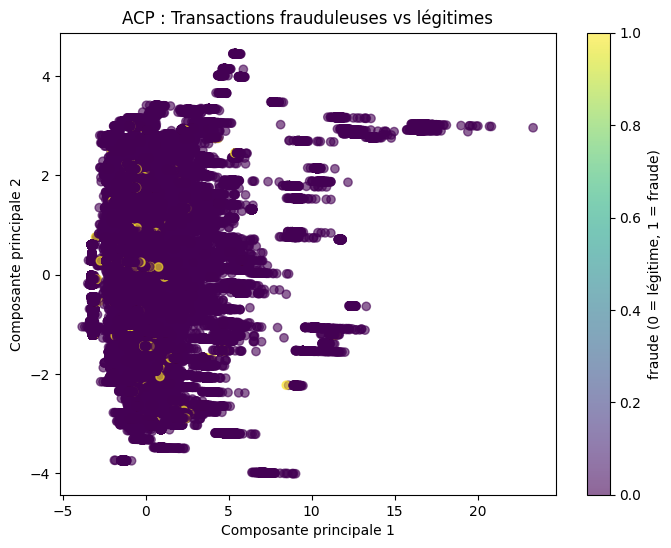

In [ ]:

num_cols = ['amount', 'per_capita_income', 'yearly_income',
            'total_debt', 'credit_score', 'num_credit_cards',
            'credit_limit', 'num_cards_issued']
 
X = df[num_cols].fillna(0)   
y = df['fraude'].astype(int) 
 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
 
# 3. ACP en 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
 
# 4. Visualisation
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.6)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("ACP : Transactions frauduleuses vs légitimes")
plt.colorbar(label="fraude (0 = légitime, 1 = fraude)")
plt.show()
 

c:\Users\Christiano\Desktop\IFT599\TP1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


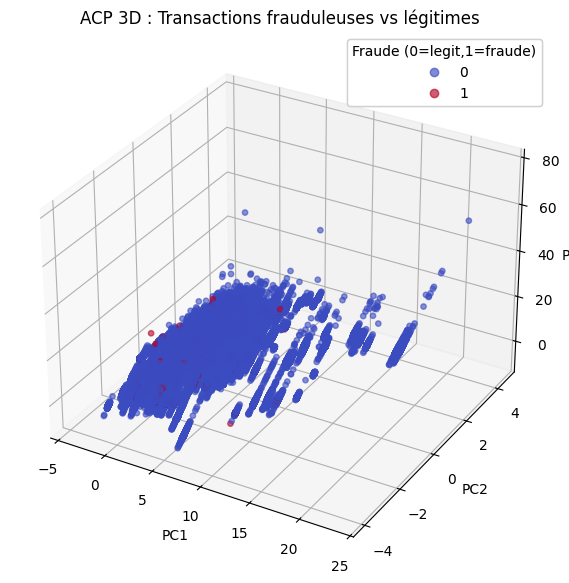

In [22]:
pca = PCA(n_components=3, random_state=42)
X3D_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X3D_pca[:,0], X3D_pca[:,1], X3D_pca[:,2],
                     c=y, cmap='coolwarm', alpha=0.6, s=15)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("ACP 3D : Transactions frauduleuses vs légitimes")

legend1 = ax.legend(*scatter.legend_elements(),
                    title="Fraude (0=legit,1=fraude)")
ax.add_artist(legend1)

plt.show()
